## **IMPORTANT NOTE**

The interactive Holoviews Graphs (cells 8, 9, 10, 16 and 17) can't be displayed in the PDF version of the notebook. However, you will still find the numerical metrics and answers to the various questions.

## **EXERCISE 1 - NETWORK ANALYSIS**

**Context:**

Let the fun begin. You will analyze network datacollected from the managers of a high-tec company. This dataset, originating from the paper below, is widely used in research on organizational networks. Time to give it a shot as well. Krackhardt D. (1987). Cognitive social structures. Social Networks, 9, 104-134. The company manufactured high-tech equipment on the west coast of the United States and had just over 100 employees with 21 managers. Each manager was asked to whom do you go to for advice and who is your friend, to whom do you report was taken from company documents. Description

The dataset includes 4 files - 3xKrack-High-Tec and 1x High-Tec-Attributes. Krack-High-Tec includes the following three 21x3 text matrices:

* ADVICE, directed, binary
* FRIENDSHIP, directed, binary
* REPORTS_TO, directed, binary

Column 1 contains the ID of the ego (from where the edge starts), and column 2 the alter (to which the edge goes). Column 3 indicates the presence (=1) or absence (=0) of an edge.

High-Tec-Attributes includes one 21x4 valued matrix.

* ID: Numeric ID of the manager
* AGE: The managers age (in years)
* TENURE: The length of service or tenure (in years)
* LEVEL: The level in the corporate hierarchy (coded 1,2 and 3; 1 = CEO, 2 = Vice President, 3 = manager)
* DEPT: The department (coded 1,2,3,4 with the CEO in department 0, ie not in a department)

## **Import Libraries and Data**

In [1]:
# import essential libraries

%%capture
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import sparse
import community.community_louvain as community_louvain

sns.set()

In [2]:
# install the visualization libraries and backend

%%capture
!pip install -qq holoviews
!pip install -qq -U bokeh
!pip install -qq datashader

# import the visualization libraries and backend

import holoviews as hv
from holoviews import opts
hv.extension('bokeh')
from bokeh.plotting import show
kwargs = dict(width=800, height=800, xaxis=None, yaxis=None)
opts.defaults(opts.Nodes(**kwargs), opts.Graph(**kwargs))
from holoviews.operation.datashader import datashade, bundle_graph

In [3]:
# import and format data

# attributes
attributes = pd.read_csv('https://raw.githubusercontent.com/SDS-AAU/SDS-master/master/00_data/network_krackhard/Krack-High-Tec-Attributes.csv')
attributes.rename(str.lower, axis=1, inplace=True)

# advice
advice = pd.read_csv('https://raw.githubusercontent.com/SDS-AAU/SDS-master/master/00_data/network_krackhard/Krack-High-Tec-edgelist-Advice.txt', sep=' ',
                     names=['source', 'target', 'edge'])
advice = advice[advice['edge'] == 1]

# friendship
friendship = pd.read_csv('https://raw.githubusercontent.com/SDS-AAU/SDS-master/master/00_data/network_krackhard/Krack-High-Tec-edgelist-Friendship.txt', sep=' ',
                     names=['source', 'target', 'edge'])
friendship = friendship[friendship['edge'] == 1]

# reportsto
reportsto = pd.read_csv('https://raw.githubusercontent.com/SDS-AAU/SDS-master/master/00_data/network_krackhard/Krack-High-Tec-edgelist-ReportsTo.txt', sep=' ',
                     names=['source', 'target', 'edge'])
reportsto = reportsto[reportsto['edge'] == 1]

## **Initiate Networks and Nodes**

In [4]:
# initiate networks

g1 = nx.from_pandas_edgelist(advice, 'source', 'target')
g2 = nx.from_pandas_edgelist(friendship, 'source', 'target')
g3 = nx.from_pandas_edgelist(reportsto, 'source', 'target')

In [5]:
# set nodes characteristics

node_attr = attributes.set_index('id').to_dict('index')

nx.set_node_attributes(g1, node_attr)
nx.set_node_attributes(g2, node_attr)
nx.set_node_attributes(g3, node_attr)

In [6]:
# set nodes centralities

# g1
nx.set_node_attributes(g1, nx.degree_centrality(g1), 'centrality_dgr')
nx.set_node_attributes(g1, nx.eigenvector_centrality_numpy(g1), 'centrality_eigen')
nx.set_node_attributes(g1, nx.betweenness_centrality(g1), 'centrality_between')

# g2
nx.set_node_attributes(g2, nx.degree_centrality(g2), 'centrality_dgr')
nx.set_node_attributes(g2, nx.eigenvector_centrality_numpy(g2), 'centrality_eigen')
nx.set_node_attributes(g2, nx.betweenness_centrality(g2), 'centrality_between')

# g3
nx.set_node_attributes(g3, nx.degree_centrality(g3), 'centrality_dgr')
nx.set_node_attributes(g3, nx.eigenvector_centrality_numpy(g3), 'centrality_eigen')
nx.set_node_attributes(g3, nx.betweenness_centrality(g3), 'centrality_between')

## **Network Analysis and Visualization**


In [7]:
# set the networkize function

def networkize(network):

  # network level characteristics
  print()
  print('Density:', nx.density(network))
  print('Transitivity:', nx.transitivity(network))
  print('Diameter:', nx.diameter(network))
  print('Average shortest path length:', nx.average_shortest_path_length(network))
  print()

  # create and save a layout
  g_layout = nx.layout.spring_layout(network) 
  g_plot = hv.Graph.from_networkx(network, g_layout).opts(tools=['hover'], node_color='community')
  labels = hv.Labels(g_plot.nodes, ['x', 'y'], 'index')

  # plot the network
  bundled = bundle_graph(g_plot)
  show(hv.render(bundled * labels.opts(text_font_size='6pt', text_color='white', bgcolor='gray')))

  # top nodes
  nodes_df = pd.DataFrame.from_dict(dict(network.nodes(data=True)),orient='index')
  print()
  print(nodes_df['centrality_dgr'].nlargest(1))
  print(nodes_df['centrality_eigen'].nlargest(1))
  print(nodes_df['centrality_between'].nlargest(1))	

  # correlation with level
  print()
  print("Kendall Tau correlation coefficient:", nodes_df['level'].corr(nodes_df['centrality_between']))

In [8]:
# g1

networkize(g1)


Density: 0.6904761904761905
Transitivity: 0.7345088161209068
Diameter: 2
Average shortest path length: 1.3095238095238095




15    1.0
Name: centrality_dgr, dtype: float64
15    0.288438
Name: centrality_eigen, dtype: float64
15    0.047759
Name: centrality_between, dtype: float64

Kendall Tau correlation coefficient: -0.12167838548981282


***Question: Who is most popular in the networks. Who is the most wanted advice giver?***

Id 15 is the most popular employee of the Advice Network. 



---


***Question: Are managers in higher hierarchy more popular advice giver?***

Not particularly since the correlation is < 20%.

In [9]:
# g2

networkize(g2)


Density: 0.3761904761904762
Transitivity: 0.4714946070878274
Diameter: 3
Average shortest path length: 1.6476190476190475




17    0.9
Name: centrality_dgr, dtype: float64
17    0.412741
Name: centrality_eigen, dtype: float64
17    0.231253
Name: centrality_between, dtype: float64

Kendall Tau correlation coefficient: 0.19157176524270395


***Question: Are friends of your friends also your friends?***

Not necessary, for example we can see that id 3 is friend with ids 10 and 14 but these ids are not friends.


---


***Question: Are the employees generally more likely to be in a friendship or advice-seeking relationship? Advice-seeking relationship***

Employees are more likely to be in an advice-seeking relationship: higher density and transitivity.


---


***Question: Who is most popular in the networks. Who is the most wanted friend?***

Id 17 is the most popular employee of the Friendship Network. 


---


***Question: Are managers in higher hierarchy more popular friendship?***

Not particularly since the correlation is < 20%.

In [10]:
# g3

networkize(g3)


Density: 0.09523809523809523
Transitivity: 0
Diameter: 4
Average shortest path length: 2.980952380952381




14    0.4
Name: centrality_dgr, dtype: float64
14    0.606507
Name: centrality_eigen, dtype: float64
7    0.752632
Name: centrality_between, dtype: float64

Kendall Tau correlation coefficient: -0.9529675058730684


***Question: Who is most popular in the network?***

Id 7 is the most popular employee of the Reports to Network since it connects all the Network (CEO).



---

***Conclusion:***

"Advice" presents the higher metrics, and "Reports to" the lowest ones. This result is coherent since an advice is the less formal type of communication in companies. On the other side, friendship takes time and Management Reporting is very structured.

We can clearly see the differences between the three types of relation. "Advice" tends to transit very easily through the network with a lot of connections. "Friendship" is less dense and more spread out. Finally, we can see the Management structure through "Reports To" Network.

## **Directed Networks: Advice and Friendship**

In [11]:
# initiate networks and set nodes characteristics

g1di = nx.from_pandas_edgelist(advice, 'source', 'target', create_using = nx.DiGraph)
g2di = nx.from_pandas_edgelist(friendship, 'source', 'target', create_using = nx.DiGraph)

nx.set_node_attributes(g1di, node_attr)
nx.set_node_attributes(g2di, node_attr)

In [12]:
# calculate dimensional centralities

cent_degree_g1di = dict(g1di.in_degree)
cent_degree_g2di = dict(g2di.in_degree)

nx.set_node_attributes(g1di, cent_degree_g1di, 'cent_degree')
nx.set_node_attributes(g2di, cent_degree_g2di, 'cent_degree')

In [13]:
# assortiativity of advice 

print('Assortiativity of Advice/Dept:', nx.attribute_assortativity_coefficient(g1di, 'dept'))
print('Assortiativity of Advice/Level:',nx.attribute_assortativity_coefficient(g1di, 'level'))
print('Assortiativity of Advice/Age:',nx.attribute_assortativity_coefficient(g1di, 'age'))
print('Assortiativity of Advice/Tenure:',nx.attribute_assortativity_coefficient(g1di, 'tenure'))	

Assortiativity of Advice/Dept: 0.02390296111309304
Assortiativity of Advice/Level: 0.008073817762398955
Assortiativity of Advice/Age: -0.03149370125974804
Assortiativity of Advice/Tenure: -0.045709982040437976


***Question: Are managers from the same 1. department, or on the same 2. hierarchy, 3. age, or 4. tenuere more likely to give advice?***

No, attributes don't seem to have an impact on giving advice.

In [14]:
# assortiativity of friendship 

print('Assortiativity of Friendship/Dept:', nx.attribute_assortativity_coefficient(g2di, 'dept'))
print('Assortiativity of Friendship/Level:',nx.attribute_assortativity_coefficient(g2di, 'level'))
print('Assortiativity of Friendship/Age:',nx.attribute_assortativity_coefficient(g2di, 'age'))
print('Assortiativity of Friendship/Tenure:',nx.attribute_assortativity_coefficient(g2di, 'tenure'))	

Assortiativity of Friendship/Dept: 0.15908798145047023
Assortiativity of Friendship/Level: 0.18750000000000006
Assortiativity of Friendship/Age: -0.031914893617021274
Assortiativity of Friendship/Tenure: -0.05271678640089042


***Question: Are managers from the same 1. department, or on the same 2. hierarchy, 3. age, or 4. tenuere more likely to become friends?***

We can see that managers of the same level or department have more probabilities to build friendship.

In [15]:
# reciprocity 

print('Reciprocity of Advice:', nx.overall_reciprocity(g1di))
print('Reciprocity of Friendship:', nx.overall_reciprocity(g2di))

Reciprocity of Advice: 0.47368421052631576
Reciprocity of Friendship: 0.45098039215686275


***Question: Are relationships like friendship and advice giving usually reciprocal?***

No the directed networks present a reciprocity coefficient inferior to 50%.

In [16]:
# plot advice network with initial layout 
G_layout = nx.layout.kamada_kawai_layout(g1di)

g_plot = hv.Graph.from_networkx(g1di, G_layout).opts(tools=['hover'],
                                                                        directed=True,
                                                                        edge_alpha=0.25,
                                                                        node_size='cent_degree',
                                                                        legend_position='right')
show(hv.render(g_plot))

In [17]:
# plot advice network with friendship layout 
G_layout = nx.layout.kamada_kawai_layout(g2di)

g_plot = hv.Graph.from_networkx(g1di, G_layout).opts(tools=['hover'],
                                                                        directed=True,
                                                                        edge_alpha=0.25,
                                                                        node_size='cent_degree',
                                                                        legend_position='right')
show(hv.render(g_plot))

***Question: Are friends more likely to give each others advice?***

Yes we can see on the graphs a higher density of Advice connections from the Friendship layout.

## **EXERCISE 2 - NLP**

**Context: Building a Hate Speech Classifier**

This assignment is less structured than previous individual assignments.

You are given a collection of approximately 25k tweets that have been manually (human) annotated. class denotes: 0 - hate speech, 1 - offensive language, 2 - neither

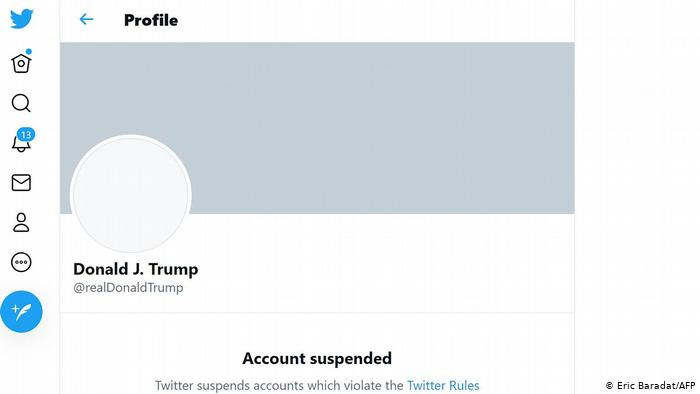

## **Import Libraries and Data**

In [18]:
# install tweet-preprocessor
!pip install tweet-preprocessor -qq

In [19]:
# import nlp libraries
import preprocessor as prepro
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline as make_pipeline_imb

# import wordcloud libraries
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

#import ml libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [20]:
# import data
tweets = pd.read_csv('https://github.com/SDS-AAU/SDS-master/raw/master/M2/data/twitter_hate.zip')
tweets.drop("Unnamed: 0", axis=1, inplace=True)
tweets.head()

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


## **Preprocessing, vectorization and prediction model**

In [21]:
# set preprocessor
prepro.set_options(prepro.OPT.URL, prepro.OPT.EMOJI, prepro.OPT.NUMBER, prepro.OPT.RESERVED, prepro.OPT.MENTION, prepro.OPT.SMILEY)
prepro.clean('Preprocessor is #awesome 👍 https://github.com/s/preprocessor')

# clean data
tweets['tweet'] = tweets['tweet'].map(lambda t: prepro.clean(t))
tweets['tweet'] = tweets['tweet'].str.replace('#', '')
tweets.head()

,class,tweet
0,2,!!! RT : As a woman you shouldn't complain abo...
1,1,!!!!! RT : boy dats cold...tyga dwn bad for cu...
2,1,!!!!!!! RT Dawg!!!! RT : You ever fuck a bitch...
3,1,!!!!!!!!! RT : she look like a tranny
4,1,!!!!!!!!!!!!! RT : The shit you hear about me ...


In [22]:
# bootstrap dictionary with spacy, remove stoppwords and lematize
nlp = spacy.load("en")

tokens = []

for tweet in nlp.pipe(tweets.sample(5000)['tweet']):
  tweet_tok = [token.lemma_.lower() for token in tweet if token.pos_ in ['NOUN', 'PROPN', 'ADJ', 'ADV'] and not token.is_stop] 
  tokens.extend(tweet_tok)

bootstrap_dictionary = list(set(tokens))

In [23]:
%%capture
# define varibales
X = tweets['tweet']
y = tweets['class']

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 21)

# instantiate model
model = make_pipeline_imb(TfidfVectorizer(vocabulary=bootstrap_dictionary), 
                          RandomUnderSampler(),
                          LogisticRegression())

# fit model
model.fit(X_train, y_train)

Model score: 0.7893887431914465
              precision    recall  f1-score   support

           0       0.20      0.63      0.31       264
           1       0.98      0.77      0.86      3854
           2       0.71      0.93      0.80       839

    accuracy                           0.79      4957
   macro avg       0.63      0.78      0.66      4957
weighted avg       0.89      0.79      0.82      4957




(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa098ff6650>)

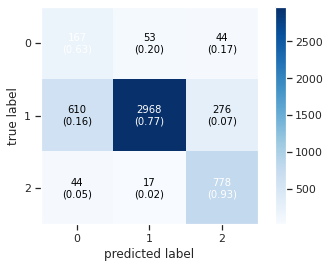

In [24]:
# model score
print("Model score:", model.score(X_test, y_test))

# prediction
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

# confusion matrix
print(classification_report(y_test, y_pred))
print()
confmatrix = confusion_matrix(y_test,y_pred) 
plot_confusion_matrix(conf_mat=confmatrix, colorbar=True, show_absolute=True, show_normed=True)

***Conclusion:***

We obtained an overall accuracy of 79% for the prediction model which is fine, even if the model struggles to correctly predict hate speech.

## **Explore and compare the 2 “classes of interest” - hate speech vs offensive language**

In [25]:
# look at probabilities
subset_tweets = tweets.copy()
subset_tweets['proba_hate'] = pd.Series(y_pred_proba[:,0])
subset_tweets['proba_offensive'] = pd.Series(y_pred_proba[:,1])


subset_tweets.head()

,class,tweet,proba_hate,proba_offensive
0,2,!!! RT : As a woman you shouldn't complain abo...,0.257739,0.583248
1,1,!!!!! RT : boy dats cold...tyga dwn bad for cu...,0.026578,0.955190
2,1,!!!!!!! RT Dawg!!!! RT : You ever fuck a bitch...,0.308734,0.685838
3,1,!!!!!!!!! RT : she look like a tranny,0.098536,0.744404
4,1,!!!!!!!!!!!!! RT : The shit you hear about me ...,0.712181,0.205738


In [26]:
for tweet in subset_tweets.sort_values('proba_hate', ascending = False)['tweet'][:10]:
  print(tweet)
  print('\n')

amen little mama. y does this old southern country bitch like you so much I don't know. but I do!


&8220;: No one likes i n d i r e c t ass bitches.&8221; &128079;


thank you for the lyrics, these bitches so gullible an sleep on your music they just be like aw u so sweet let me suck ur dick


": Fit lads! Nice gear! " these scally lads n trainers would get it


": "I don't want to have sex with my gf because I feel like I'm using her.." - anonymous" Whata faggot


straight up your hoes can wait !


&8220;: bitches be set hoppin like bitch get your life for u get beat up lmao&8221;


is having a birthday so make sure you tell that bitch be happy. &128526;&128522; &127881; &amp; celebrate without drugs &128683;


"Uh-uh, what do we have? Your empty heart, my empty bottle, a yellow cab.. That you would like to catch cuz yo latest ex made u mad..


fuck your redskins bitch!




In [27]:
for tweet in subset_tweets.sort_values('proba_offensive', ascending = False)['tweet'][:10]:
  print(tweet)
  print('\n')

Now, mfa don't wanna spend a dime wit em. Prolly out here yelling money over bitches.


&128557; RT : When you wake up to bae being a hoe on the TL


"You and yo boys some pussy cats."


slap a bitch


": If she kiss u with her eyes open watch that bitch!"lmfao


That band is white trash, and only white trash would buy that album.


": Yall still going trick or treating this year or nah?"hell yeah ima be da sweet tooth bandit steal bitches bags n shit


&8220;: lol , be cool son. You know your grandma bald mouth&8221he got all her teeth hoe &128514;&128514;


&8220;: you fck like a hoe so no thank you . Ima be classy when I do it &128128;&8221; &128128;&128128;&128128;&128128;&128128;&128128; bitch I'm dead


... That's what happens when your getting pussy. Pussy or Twitter? Seems like a clear cut choice to me. Hahahaha




***Conclusion:***

We can not clearly see the differences between the two types of Speech here so let's look at a different way of representing them. 

In [28]:
# define the wordcloud function

def wordcloud(id):
  # text of all words in tweet
  text = " ".join(review for review in tweets[tweets["class"] == id].tweet.astype(str))
  print ("There are {} words in the combination of all cells in column tweet.".format(len(text)))

  # converting jpg image to a numpy array

  twitter_mask = np.array(Image.open("/content/twitter_mask.jpg"))

  # instantiate a word cloud object
  stopwords = set(STOPWORDS)
  output_wc = WordCloud(
      background_color='white',
      stopwords=stopwords, max_words=100, mask=twitter_mask
  )

  # generate the word cloud
  output_wc.generate(text)

  # display the word cloud
  plt.tight_layout(pad=0)
  plt.figure( figsize=(12,12))
  plt.imshow(output_wc, interpolation='bilinear')
  plt.axis('off')
  plt.show()

There are 100356 words in the combination of all cells in column tweet.


<Figure size 432x288 with 0 Axes>

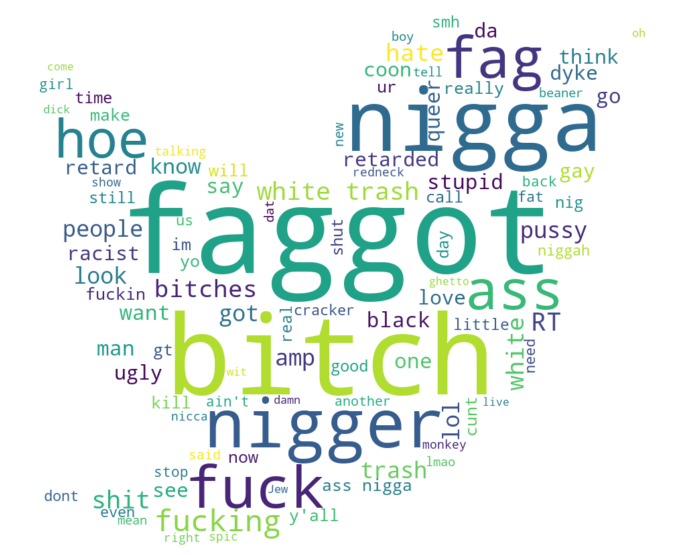

In [29]:
# wordcloud for hate speech

wordcloud(0)

There are 1355851 words in the combination of all cells in column tweet.


<Figure size 432x288 with 0 Axes>

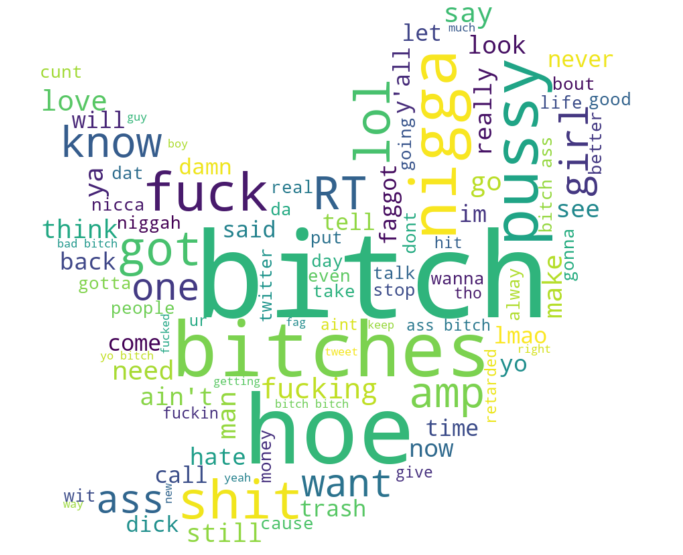

In [30]:
# wordcloud for offensive speech

wordcloud(1)

***Question: Can you identify themes (aka clusters / topics) that are specific for one class or another?***

Even if the boundary between Hate and Offensive Speech isn't very clear we noticed a dominance of a specific cluster for Hate Speech: Racist and Homophobic Insults.

In [31]:
# proportion of tweets per class
print(tweets['class'].value_counts(normalize=True))

# proportion of words per class
totalwords = " ".join(review for review in tweets.tweet.astype(str))
print(1355851/len(totalwords))
print(324044/len(totalwords))
print(100356/len(totalwords))

1    0.774321
2    0.167978
0    0.057701
Name: class, dtype: float64
0.7616057942326175
0.18202131944167485
0.05637176288988138


***Question: Can you see differences by using simple count-based approaches?***

Most of the negative tweets seems categorized as offensive speech (>90%). It makes sense since we've seen that the major difference between Hate and Offensive concerns a specific type of insult based on sexuality and origins. 